In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.metrics import f1_score, accuracy_score

import optuna

/home/m_trofimov/.conda/envs/ds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

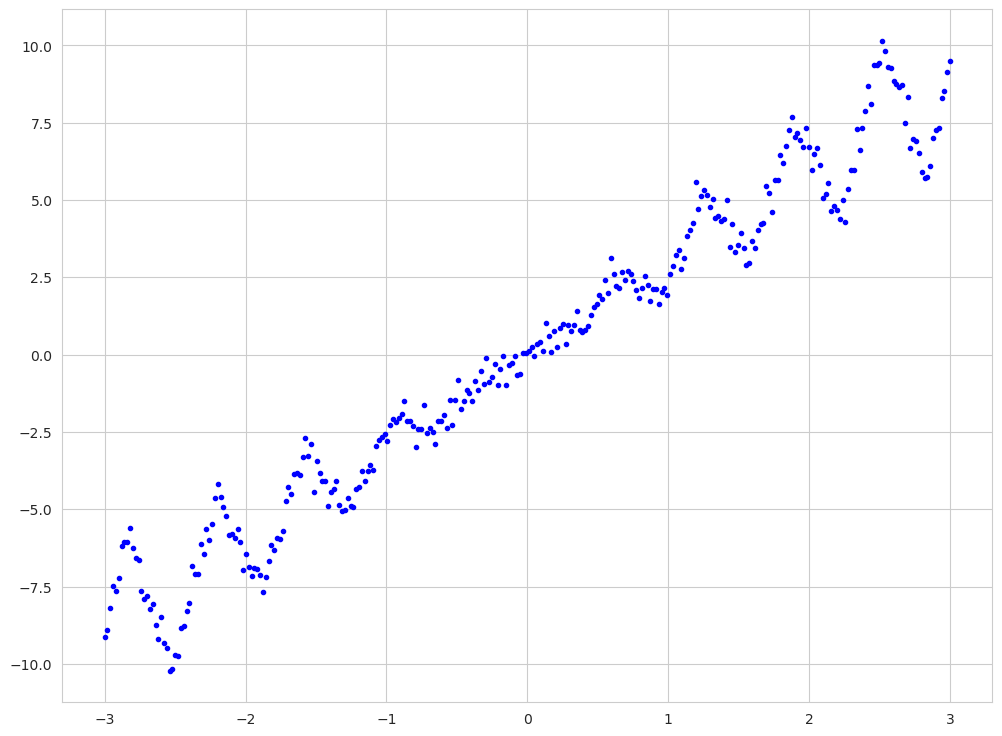

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", ax=None, d=None):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    ax.axis(axes)
    ax.set_xlabel("$x_1$", fontsize=18)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=18, rotation=0)

    ax.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    ax.set_title(f'depth:{d}')

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

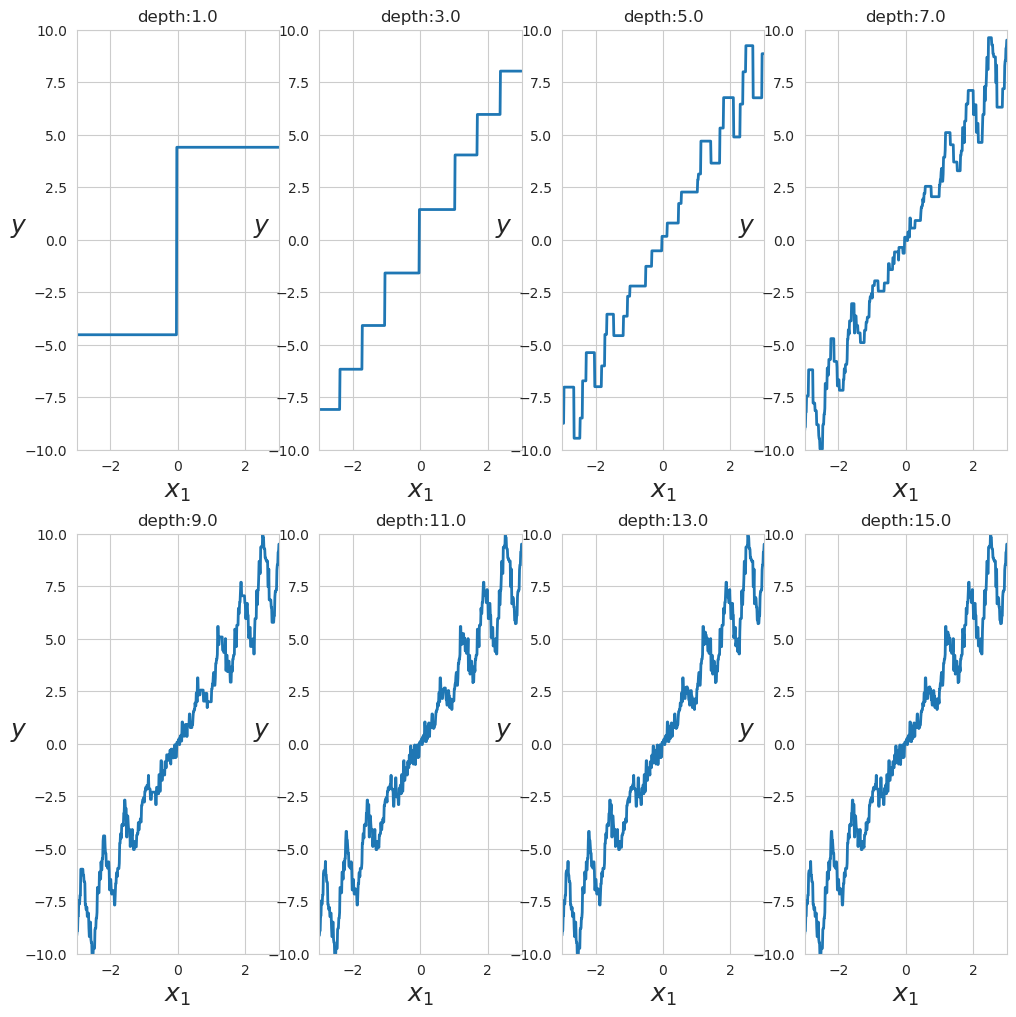

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
fig, axs = plt.subplots(2,4, figsize=(12,12))
depth = np.linspace(1,15,8)

for ax,d in zip(axs.flatten(), depth):
    tree = DecisionTreeRegressor(max_depth=int(d)).fit(X,y)
    plot_regression_predictions(tree,X,y,ax=ax,d=d)


С глубины 7 и выше не наблюдается сильная дисперсия. До этого дисперсия довольна высока. Но с глубины 9 идет оверфит

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

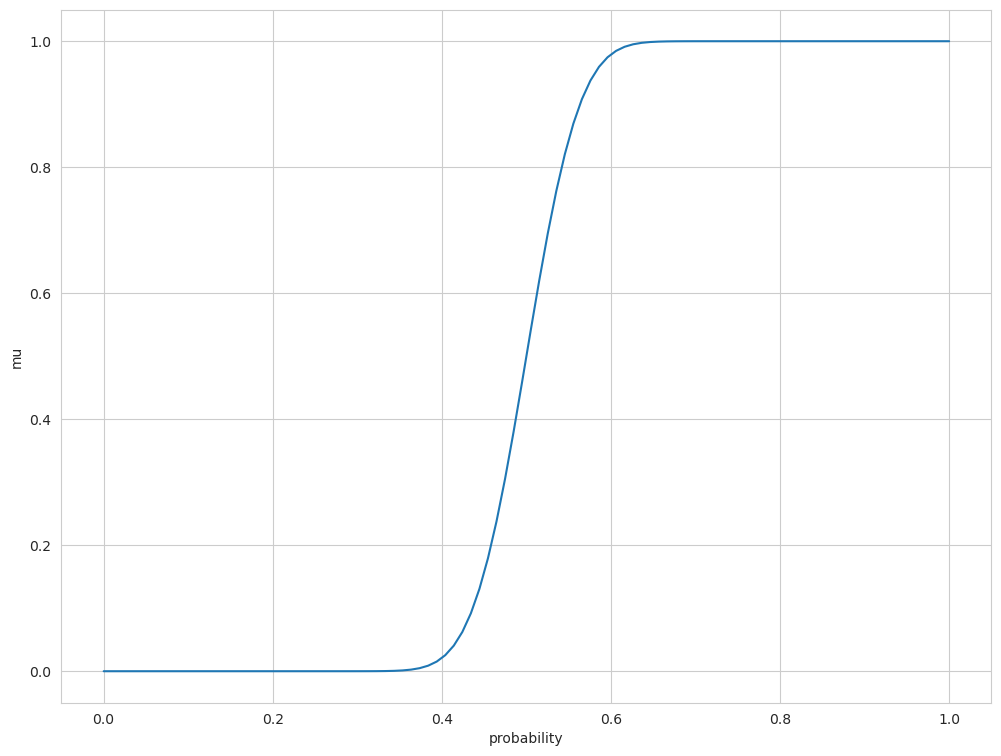

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
def calc_mu(prob):

    res = []
    for p in prob:
        mu_list = []
        for i in range(51,102):
            c = math.comb(101, i) 
            mu = c * p**i * (1 - p)**(101-i)
            mu_list.append(mu)
        res.append(np.array(mu_list).sum())

    return res
p=np.linspace(0,1,100)

res = calc_mu(p)

plt.plot(p,res)
plt.xlabel('probability')
plt.ylabel('mu');

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

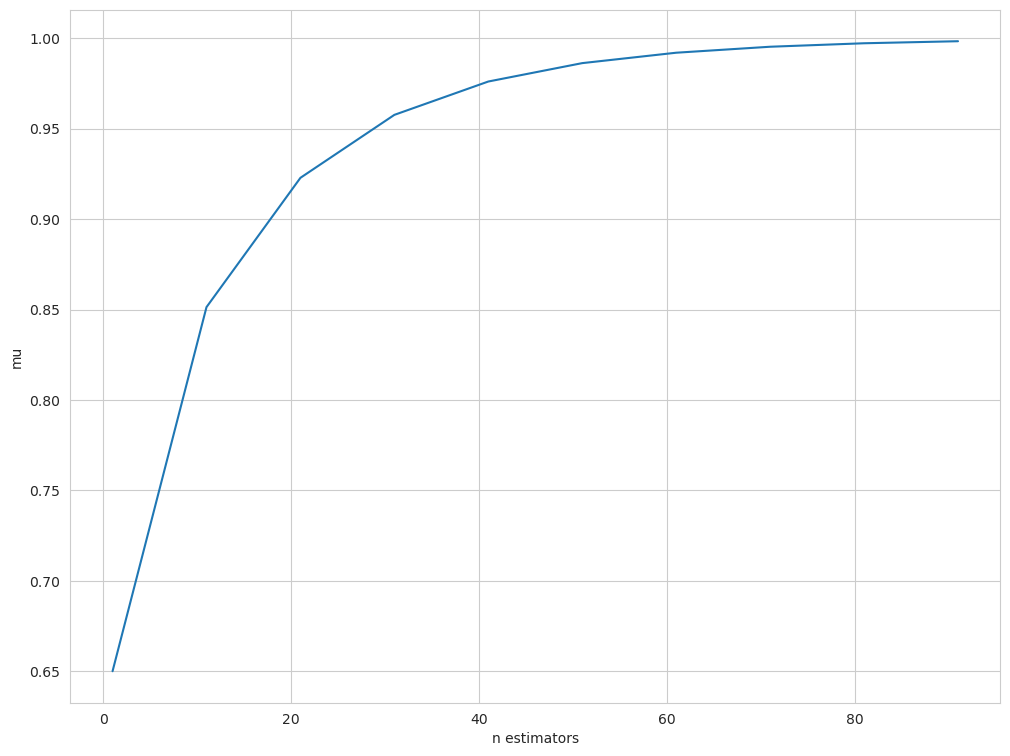

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
def calc_mu(n_est):

    res = []

    for n in n_est:
        n_half = n // 2 + 1
        mu_list = []
        for i in range(n_half,n+1):
            c = math.comb(n, i) 
            mu = c * 0.65**i * (1 - 0.65)**(n-i)
            mu_list.append(mu)
        res.append(np.array(mu_list).sum())

    return res
n_est=np.arange(1,100,10)

res = calc_mu(n_est)

plt.plot(n_est,res)
plt.xlabel('n estimators')
plt.ylabel('mu');

Опишите ваши наблюдения:

* модель зависимости вероятности правильного предсказания объекта от вероятности предсказания слабого классификатора имеет вид сигмоиды. Перегиб графика начинается при вероятности 0.5
* экспоненциальный рост вероятности правильного предсказания от количества слабых классификаторов

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(X.shape[1], size=self.max_features, replace=False)
            if type(feat_ids) is int:
                feat_ids = [feat_ids]
            self.feat_ids_by_tree.append(feat_ids)
            bootstrap_indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state
            )
            tree.fit(np.reshape(X_bootstrap[:,feat_ids], (-1,len(feat_ids))), y_bootstrap)
            self.trees.append(tree)
            
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        probas = np.zeros((X.shape[0], len(self.classes_)))
        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            probas += tree.predict_proba(np.reshape(X[:, feat_ids],(-1,len(feat_ids))))
        return probas / len(self.trees)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions


Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

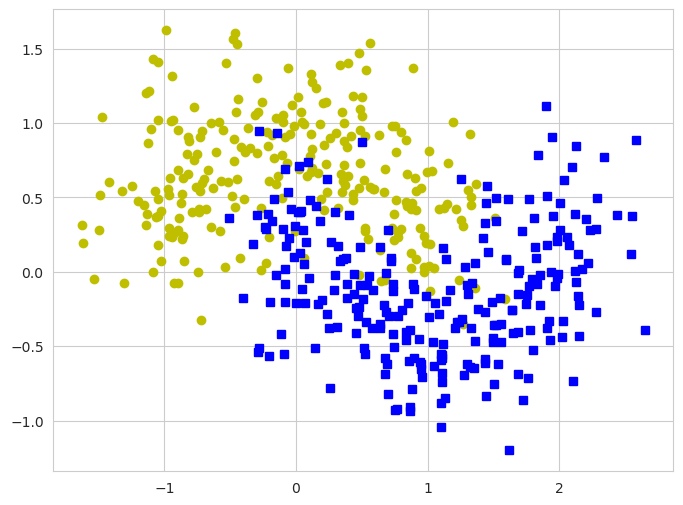

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

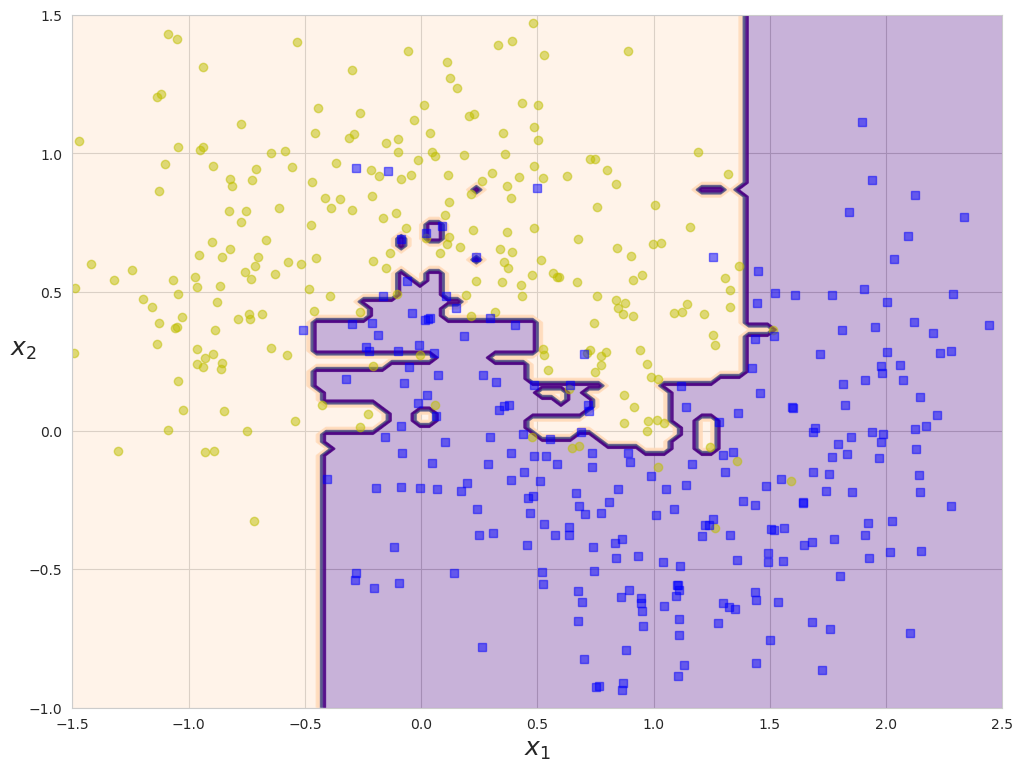

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
clf = RandomForestClassifierCustom(max_features=2).fit(X=X,y=y)
plot_decision_boundary(clf, X,y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

f1: 0.921038562641152


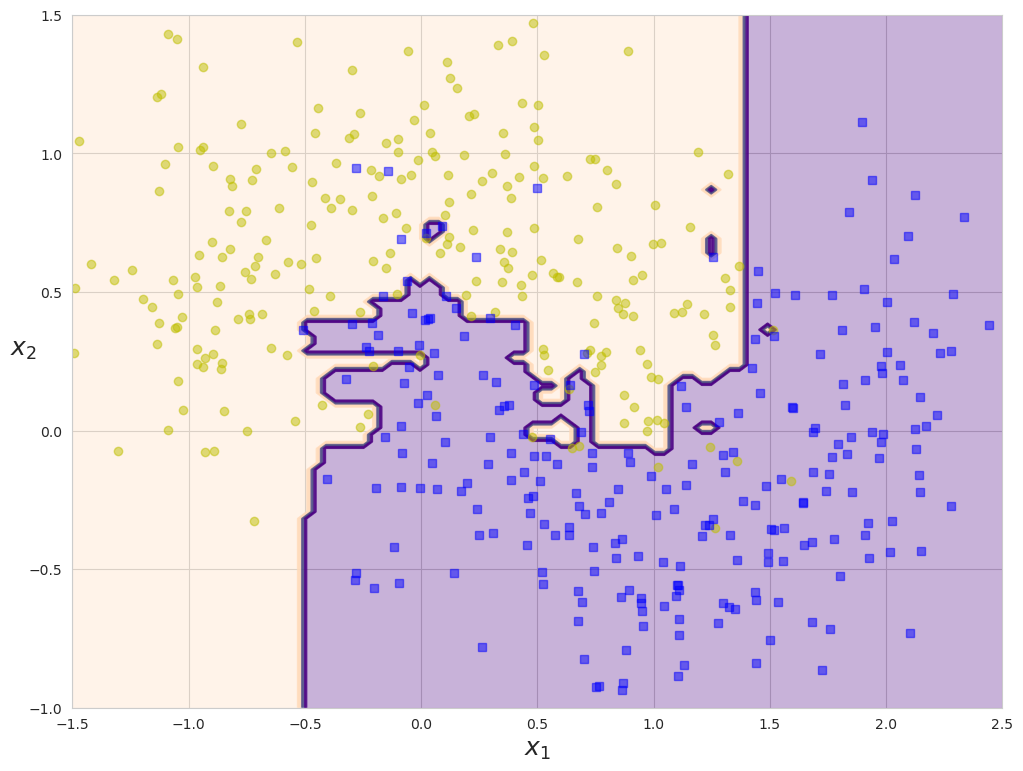

In [21]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
params = {
    'max_depth' : [1,2,5,10,15,20],
    'n_estimators' : [1,2,25,50,100],
    'max_features' : [1,2,3,5,6,7,10,12,14]
}

clf = GridSearchCV(RandomForestClassifierCustom(),params, scoring='f1', n_jobs=-1)
clf.fit(X,y)

best_clf = clf.best_estimator_
best_clf.fit(X,y)

plot_decision_boundary(best_clf, X,y)
print(f'f1: {clf.best_score_}')

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [22]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [23]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

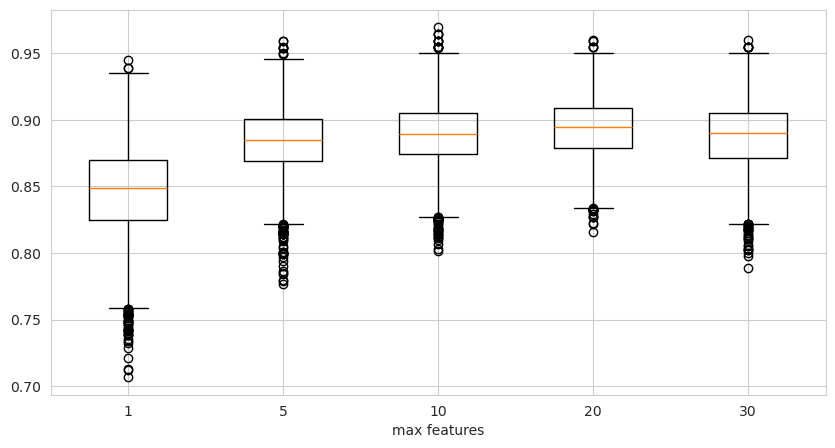

In [24]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_features_values = [1, 5, 10, 20,30]
correlation_matrix = []

for max_features in max_features_values:
    model = RandomForestClassifier(max_features=max_features, random_state=SEED)
    model.fit(X_train, y_train)
    
    correlation_list = base_model_pair_correlation(model, X_train)
    correlation_matrix.append(correlation_list)

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(correlation_matrix, labels=max_features_values)

ax.set_xlabel('max features');

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

Text(0.5, 0, 'max depth')

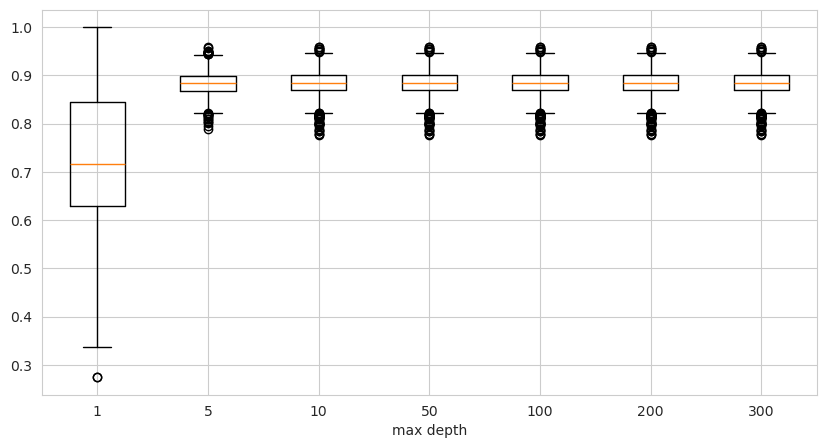

In [25]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
max_depth_values = [1, 5, 10, 50, 100, 200, 300]
correlation_matrix = []

for max_depth in max_depth_values:
    model = RandomForestClassifier(max_depth=max_depth, random_state=SEED)
    model.fit(X_train, y_train)
    
    correlation_list = base_model_pair_correlation(model, X_train)
    correlation_matrix.append(correlation_list)

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(correlation_matrix, labels=max_depth_values)
ax.set_xlabel('max depth')

Опишите ваши наблюдения:

- при увеличении фичей, увеличивается корреляция между базовыми моделями, но не превышает значение в 0.9

- при увеличении глубины базовых моделей, корреляция между базовыми моделями выходит на плато около 0.9 если больше 1 модели


### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [26]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [27]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [28]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [29]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_soft = VotingClassifier(base_models, voting='soft')
voting_hard = VotingClassifier(base_models, voting='hard')
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [30]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_soft = VotingClassifier(base_models, voting='soft')
voting_hard = VotingClassifier(base_models, voting='hard')

voting_soft.fit(X_train, y_train)
voting_hard.fit(X_train, y_train)

correlation_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_train)
correlation_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

sorted_correlation_soft = sorted(correlation_soft, key=lambda x: x[-1], reverse=True)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [32]:
voting_soft = VotingClassifier([("RF", rf),("XGB_RF", xgb_rf),("LGBM_RF", lgbm_rf),("CAT", cat), ("ETC", etc)], voting='soft')

scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean():.3f}")

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[Li

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [3]:
pd.set_option('display.max_columns',400)
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
cols = ['Account Length','VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge',
       'Night Mins', 'Night Calls', 'Night Charge',
       'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?']

data = data[cols]
data.iloc[:,-1] = data.iloc[:,-1].str.slice(0,-1)
data.iloc[:,-1] = data.iloc[:,-1].astype('category') 
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [13]:
class ObjectiveCV(object):
    def __init__(self, X_data, y_data, multilabel_data):
        self.X_data = X_data
        self.y_data = y_data
        self.multilabel_data = multilabel_data

    def __call__(self, trial):

        params = {
            'class_weight': 'balanced',
            'objective': 'binary',
            "metric": "f1",
            "verbosity": -1,
            "n_jobs": 2,
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 9),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),  # n_trees
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 10.0, log=True),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 5000),
            "max_depth": trial.suggest_int("max_depth", 3, 17),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            
        }

        params["num_leaves"] = 2 ** params["max_depth"]

        cv = StratifiedKFold(
            n_splits=3, 
            shuffle=True,
            random_state=42
        )

        result = []
        for train_index, test_index in cv.split(self.X_data, self.y_data):
            X_train, X_test = (
                self.X_data.iloc[train_index],
                self.X_data.iloc[test_index],
            )
            y_train, y_test = (
                self.y_data.iloc[train_index],
                self.y_data.iloc[test_index],
            )

            model = lightgbm.LGBMClassifier(**params)
            model.fit(X_train.astype(float), y_train)
            y_pred = model.predict(X_test)
            f1_val = f1_score(y_test, y_pred, average="macro")

            result.append(f1_val)

        mean_f1 = np.mean(result)
        
        return mean_f1

In [14]:
objective_cv = ObjectiveCV(X_train, y_train, y_train)

study_cv = optuna.create_study(direction="maximize")
study_cv.optimize(objective_cv, n_trials=500, n_jobs=15)

[I 2024-03-15 02:11:02,100] A new study created in memory with name: no-name-dfd530b8-53f4-418b-939d-e83a67c0689e
[I 2024-03-15 02:11:02,933] Trial 12 finished with value: 0.23711175797382691 and parameters: {'bagging_freq': 3, 'n_estimators': 90, 'lambda_l1': 0.01677066735979202, 'lambda_l2': 0.026235107218545762, 'feature_fraction': 0.4391378728203017, 'bagging_fraction': 0.8887927821105168, 'min_child_samples': 1089, 'max_depth': 10, 'learning_rate': 0.002875017849495655, 'subsample': 0.7743791640507557}. Best is trial 12 with value: 0.23711175797382691.
[I 2024-03-15 02:11:03,021] Trial 10 finished with value: 0.6029989217751686 and parameters: {'bagging_freq': 6, 'n_estimators': 55, 'lambda_l1': 1.5890083989615598, 'lambda_l2': 2.6023421102187214, 'feature_fraction': 0.5086528591252024, 'bagging_fraction': 0.9682498568153305, 'min_child_samples': 562, 'max_depth': 9, 'learning_rate': 0.02252144718941679, 'subsample': 0.8534556121347331}. Best is trial 10 with value: 0.602998921775

In [17]:
best_params_cv = study_cv.best_params
print("Best Hyperparameters with OptunaCV:", best_params_cv)

best_model = lightgbm.LGBMClassifier(**best_params_cv)
best_model.fit(X_train, y_train)

y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

print(f'lightgbm. train f1 {f1_score(y_train, y_train_predict, average="macro")}')
print(f'lightgbm. test f1 {f1_score(y_test, y_test_predict, average="macro")}')

print(f'lightgbm. train accuracy {accuracy_score(y_train, y_train_predict)}')
print(f'lightgbm. test accuracy {accuracy_score(y_test, y_test_predict)}')

Best Hyperparameters with OptunaCV: {'bagging_freq': 2, 'n_estimators': 452, 'lambda_l1': 0.12370978387933994, 'lambda_l2': 0.015553611460474046, 'feature_fraction': 0.7378257964742152, 'bagging_fraction': 0.5225008767518613, 'min_child_samples': 6, 'max_depth': 14, 'learning_rate': 0.0056193688195956696, 'subsample': 0.26167714338997633}
[LightGBM] [Warning] feature_fraction is set=0.7378257964742152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7378257964742152
[LightGBM] [Warning] lambda_l2 is set=0.015553611460474046, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015553611460474046
[LightGBM] [Warning] lambda_l1 is set=0.12370978387933994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12370978387933994
[LightGBM] [Warning] bagging_fraction is set=0.5225008767518613, subsample=0.26167714338997633 will be ignored. Current value: bagging_fraction=0.5225008767518613
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be 

In [18]:
params = {'n_estimators' : [10,50,100,150,250],
        'max_depth'    : [10,20,30,50,100],
        'min_samples_split' : [2, 5, 10, 15]}

model = RandomForestClassifier(random_state=SEED)
clf = GridSearchCV(model, params, n_jobs=15)
clf.fit(X_train,y_train)

best_model = clf.best_estimator_
best_model.fit(X_train, y_train)

y_train_predict = best_model.predict(X_train)
y_test_predict = best_model.predict(X_test)

print(f'random forest. train f1 {f1_score(y_train, y_train_predict,average='macro')}')
print(f'random forest. test f1 {f1_score(y_test, y_test_predict,average='macro')}')

print(f'random forest. train accuracy {accuracy_score(y_train, y_train_predict)}')
print(f'random forest. test accuracy {accuracy_score(y_test, y_test_predict)}')

random forest. train f1 1.0
random forest. test f1 0.7967437203430412
random forest. train accuracy 1.0
random forest. test accuracy 0.9160419790104948


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Второе задание очень интересное, не встречал такого раньше) Было здорово, спасибо!